#### This notebook generates convergence plots for the backward Euler and the implicit midpoint method on the Van Der Pol equation.

Requires Nodepy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
weights_lib = { 
                'Euler 1-step 1-order' : [1],
                'Euler 2-step 2-order' : [0.5 +0.5*1j, 0.5-0.5*1j],
                'Euler 2-step 3-order' : [1+1j*np.sqrt(2)/2,-1j*np.sqrt(2)/2],
                'Euler 2-step 3-order exp' : [0.838852+1j*0.604004, 0.161148-1j*0.604004],
                'Euler 2-step symplectic' : [0.5 +0.5*np.sqrt(3)*1j, 0.5-0.5*np.sqrt(3)*1j],
                'Euler 3-step 1-order' : [8.29344624e-01 , 5.95442650e-02, 1-8.29344624e-01-5.95442650e-02],
                'Euler 3-step 3-order' : [0.1867308533646 + 0.480773884550331*1j, 0.626538293270800, 0.1867308533646 - 0.480773884550331*1j],
                'Euler 3-step 2-order' : [0.411741936185254 + 0.430244574248458*1j, 0.176516127629493, 0.411741936185254-0.430244574248458*1j],
                'Euler 4-step 4-order' : [   0.04262665650273905+0.394632953172082*1j,
                                           0.4573733434973006-0.23510048799854047j, 0.4573733434973006+0.23510048799854047j, 0.04262665650273905-0.394632953172082*1j],
                'Euler 4-step 5-order' :[0.468161714486717 - 0.26941588085837*1j, 0.160647423722113 + 0.351192187389791*1j,0.335788810038662 + 0.241712151385474*1j, 
                                         0.0354020517525083 - 0.323488457916895*1j],
                'Midpo 2-step 4-order' :[0.5 + 0.28867513459*1j, 0.5-0.28867513459*1j]}

def pathwise(x, path):
    stepsize = x[1:]-x[:-1]
    contour = [x[0]]
    for i in range(len(x)-1):
        weights = np.cumsum(weights_lib[path])
        substeps = [x[i]+stepsize[i]*weight for weight in weights]
        contour +=substeps
    return np.array(contour)

In [3]:
def F(u, step, u_old):
    return np.array([ u[0] - u_old[0] - step*u[1],
                      u[1] - u_old[1] - (step/eps)*((1-u[0]**2)*u[1])+step*u[0]])

def Jac(u, step):
    return np.array([[1 , -step], [step+(step/eps)*2*u[0]*u[1], 1-(step/eps)*(1-u[0]**2)]])

def newton_solve(u_prev,step):
    u_old = u_prev
    for i in range(100):
        u_new = u_old - np.linalg.solve(Jac(u_old, step),F(u_old, step, u_prev))
        u_old = u_new
    return u_new

In [10]:
class IVP(object):
    def __init__(self, f=None, u0=1., t0=0., T=1., exact=None, desc='', name=''):
        self.u0  = u0
        self.rhs = f
        self.T   = T
        self.exact = exact
        self.description = desc
        self.t0 = t0
        self.name = name

In [11]:
u0 = np.array([2.,0])
rhs = lambda t,u: np.array([u[1], (1/eps)*((1-u[0]**2)*u[1])-u[0]])
vdp_jdg = IVP(f=rhs, u0=u0, T = 20)

In [18]:
import nodepy.runge_kutta_method as rk
rk4 = rk.loadRKM('RK44')
t, u = rk4(vdp_jdg, dt = 0.000001)

In [15]:
def convergence_test(timesteps, schemes, ode, exact_soln =[]):
    error_matrix = []
    for timestep in timesteps:
        end = ode.T
        x = np.linspace(0, end, int(end/timestep)+1)
        if exact_soln ==[]:
            exact = ode.exact(x)
        else:
            #print(int(np.rint(timestep/exact_soln[1])), timestep/exact_soln[1])
            exact = np.array(exact_soln[0][::int(np.rint(timestep/exact_soln[1]))])
        
        scheme_error = []
        for scheme in schemes:
            #print(scheme)
            path1 = pathwise(x, scheme)
            steps = path1[1:]-path1[:-1]
            if isinstance(ode.u0, (list, np.ndarray)):
                y1 = np.zeros((len(path1), len(ode.u0)), dtype = np.cdouble)
            else:
                y1 = np.zeros((len(path1)), dtype = np.cdouble)
            y1[0] = ode.u0
            i = 1
            for step in steps:
                y1[i] = newton_solve(y1[i-1], step)
                if i%int(scheme[6])==0:
                    y1[i] = np.real(y1[i])
                i += 1
            scheme_error += [np.linalg.norm(y1[::int(scheme[6])]-exact, np.inf)]

        error_matrix.append(np.array(scheme_error))
    return np.array(error_matrix)
            

In [16]:
timesteps = np.array([0.01, 0.001, 0.0001])
schemes = ['Euler 1-step 1-order', 'Euler 3-step 3-order']#'Euler 2-step 3-order exp','Euler 4-step 5-order', 'Euler 3-step 2-order', 'Euler 3-step 1-order']

#schemes = ['Euler 2-step 3-order']
er = convergence_test(timesteps, schemes, vdp_jdg, exact_soln =[u, 0.00001])
er

Euler 1-step 1-order
Euler 2-step 2-order
Euler 3-step 3-order
Euler 1-step 1-order
Euler 2-step 2-order
Euler 3-step 3-order


array([[1.53873898e+01, 3.98123414e+00, 1.59138180e-01],
       [1.25004989e+01, 3.62967392e-02, 1.78487870e-04]])

# Midpoint Method

In [25]:
def convergence_test_midpoint(timesteps, schemes, ode, exact_soln =[]):
    error_matrix = []
    for timestep in timesteps:
        end = ode.T
        x = np.linspace(0, end, int(end/timestep)+1)
        if exact_soln ==[]:
            exact = ode.exact(x)
        else:
            #print(int(np.rint(timestep/exact_soln[1])), timestep/exact_soln[1])
            exact = np.array(exact_soln[0][::int(np.rint(timestep/exact_soln[1]))])
        
        scheme_error = []           
        for scheme in schemes:
            print(scheme)
            path1 = pathwise(x, scheme)
            steps = path1[1:]-path1[:-1]
            if isinstance(ode.u0, (list, np.ndarray)):
                y1 = np.zeros((len(path1), len(ode.u0)), dtype = np.cdouble)
            else:
                y1 = np.zeros((len(path1)), dtype = np.cdouble)
            y1[0] = ode.u0
            i = 1
            for step in steps:
                y1[i] = newton_solve1(y1[i-1], step)
                if i%int(scheme[6])==0:
                    y1[i] = np.real(y1[i])
                i += 1
            scheme_error += [np.linalg.norm(y1[::int(scheme[6])]-exact, np.inf)]

        error_matrix.append(np.array(scheme_error))
    return np.array(error_matrix)

In [29]:
timesteps1 = np.array([0.1, 0.01, 0.001])
schemes = ['Euler 1-step 1-order', 'Midpo 2-step 4-order'] #'Euler 2-step 2-order', 'Euler 3-step 3-order']#'Euler 2-step 3-order exp','Euler 4-step 5-order', 'Euler 3-step 2-order', 'Euler 3-step 1-order']

#schemes = ['Euler 2-step 3-order']
er1 = convergence_test_midpoint(timesteps, schemes, vdp_jdg, exact_soln =[u, 0.00001])
er1

Euler 1-step 1-order
Midpo 2-step 4-order
Euler 1-step 1-order
Midpo 2-step 4-order
Euler 1-step 1-order
Midpo 2-step 4-order


array([[1.37639809e+01, 1.35216497e+01],
       [1.76735698e+00, 1.14743826e-03],
       [1.78841644e-02, 1.14516431e-07]])

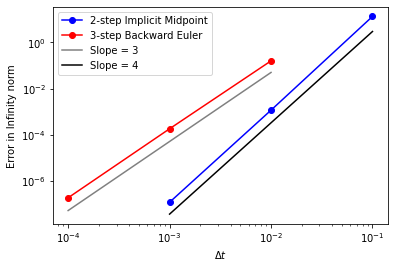

In [29]:
plt.figure()
plt.loglog( timesteps1, er1[:,1], 'b-o', label = '2-step Implicit Midpoint')
plt.loglog( timesteps, er[:,1], 'r-o', label = '3-step Backward Euler')
plt.loglog([0.01, 0.0001], [0.05, 5e-08], 'gray',  label = 'Slope = 3')
plt.loglog([0.1, 0.001], [3, 3.5e-08], 'k',  label = 'Slope = 4')
plt.xlabel(r'$\Delta t$')
plt.ylabel('Error in Infinity norm')
plt.legend()
plt.savefig('implicit_vdp.pdf')